#Import all necessary libraries

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.utils import resample


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# EDA

Read the data into dataframe & EDA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/Data02_PS_20174392719_1491204439457_log.csv')

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


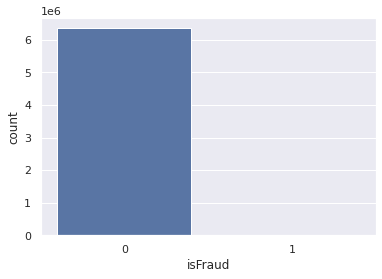

In [ ]:
sns.set_theme(style="darkgrid")
sns.countplot(x="isFraud", data=df)

In [ ]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

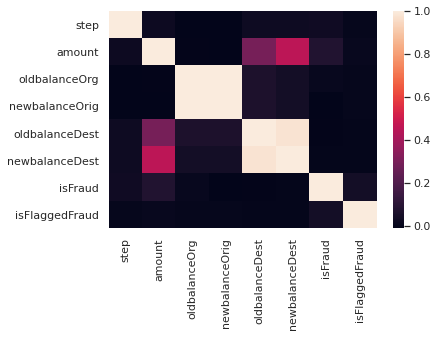

In [ ]:
sns.heatmap(df.corr())

# Data Preprocessing

In [ ]:
# check if those use for fraud transfer will be used for cash out later
fraud = df[df["isFraud"] == 1]
fraud_transfer = fraud[fraud["type"] == "TRANSFER"]
fraud_cashout = fraud[fraud["type"] == "CASH_OUT"]
fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any()

False

In [ ]:
# check the isFlaggedFraud values
flagged = df[df["isFlaggedFraud"] == 1]
flagged_correctly = sum(flagged["isFraud"] == 1)
flagged_wrongly = len(flagged) - flagged_correctly
total = flagged_correctly + flagged_wrongly
should_be_flagged = fraud[(fraud["amount"] > 200000) & (fraud["type"] == "TRANSFER")]

print("Flagged correctly: ",flagged_correctly )
print("Flagged wrongly: ",flagged_wrongly )
print("Should Flagged case: ",len(should_be_flagged) )
print("Total Fraud: ",len(fraud) )


Flagged correctly:  16
Flagged wrongly:  0
Should Flagged case:  2740
Total Fraud:  8213


In [ ]:
# as there is no similar nameOrig and nameDest in same transaction,
# there 2 are ommited as it can happen randomly in either one account
# isFlaggedFraud is ommited because 
# its percetage to the overall fraud is too small
df = df.drop(["nameOrig","nameDest","isFlaggedFraud"], axis=1)

In [ ]:
# check on which type of transaction involve fraud
df.loc[df.isFraud == 1].type.drop_duplicates().values

array(['TRANSFER', 'CASH_OUT'], dtype=object)

In [ ]:
# as fraud only found in Transfer and cash out type, other type are drop
df = df.loc[df['type'].isin(['TRANSFER','CASH_OUT'])]

In [ ]:
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,181.0,0.0,0.0,0.00,1
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0


In [ ]:
df.isFraud.value_counts()

0    2762196
1       8213
Name: isFraud, dtype: int64

In [ ]:
# one-hot encoding
df = pd.get_dummies(df)
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_OUT,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,0,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,1,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,1


In [ ]:
# Split into X and y
y = df["isFraud"].values  # target attributes
X = df.drop(["isFraud"], axis=1) # input attributes


# Feature Engineering
# Inspired by https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-services
# Balance in fraud should be less

X['difBaOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrg
X['diforBaDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest



In [ ]:
# Scale the independent variables
x_scale = preprocessing.MinMaxScaler().fit_transform(X.values)

#Standard ML training and evaluation 

In [ ]:
# reduce the size of the data as it takes too long for training
reduce_x, large_x, reduce_y, large_y = train_test_split(x_scale, y,
                                                  test_size=0.90, stratify=y)
# data splitting
train_x, val_x, train_y, val_y = train_test_split(reduce_x, reduce_y,
                                                  test_size=0.4, stratify=reduce_y)


In [ ]:
train_x.shape

(166224, 10)

In [ ]:
val_x.shape

(110816, 10)

## Supervised ML techniques

### DT

In [ ]:
# Decision Tree
DT_clf = DecisionTreeClassifier().fit(train_x, train_y)
# tree.plot_tree(DT_clf)

In [ ]:
# DT Performance Evaluation
pred_y_DT = DT_clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_DT))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_DT, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_DT))
precision = precision_score(val_y, pred_y_DT)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_DT)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_DT))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_DT))





Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110488
           1       0.96      0.96      0.96       328

    accuracy                           1.00    110816
   macro avg       0.98      0.98      0.98    110816
weighted avg       1.00      1.00      1.00    110816


Confusion Matrix: 
 [[   316     12]
 [    14 110474]]
Accuracy Score:  0.9997653768408894
Precision Score:  0.9575757575757575
Recall Score:  0.9634146341463414
F1 Score:  0.9604863221884499
ROC AUC:  0.9816439617766679


### LR

In [ ]:
# Logistic regression
LR_clf = LogisticRegression().fit(train_x, train_y)


In [ ]:
# LR Performance Evaluation
pred_y_LR = LR_clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_LR))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_LR, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_LR))
precision = precision_score(val_y, pred_y_LR)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_LR)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_LR))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_LR))





Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110488
           1       1.00      0.01      0.01       328

    accuracy                           1.00    110816
   macro avg       1.00      0.50      0.51    110816
weighted avg       1.00      1.00      1.00    110816


Confusion Matrix: 
 [[     2    326]
 [     0 110488]]
Accuracy Score:  0.9970581865434595
Precision Score:  1.0
Recall Score:  0.006097560975609756
F1 Score:  0.012121212121212121
ROC AUC:  0.5030487804878049


### SVM

In [ ]:
# Support Vector Machine
SVM_clf = svm.SVC().fit(train_x, train_y)


In [ ]:
# SVM Performance Evaluation
pred_y_SVM = SVM_clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_SVM))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_SVM, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_SVM))
precision = precision_score(val_y, pred_y_SVM)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_SVM)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_SVM))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_SVM))




Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110488
           1       1.00      0.04      0.07       328

    accuracy                           1.00    110816
   macro avg       1.00      0.52      0.53    110816
weighted avg       1.00      1.00      1.00    110816


Confusion Matrix: 
 [[    12    316]
 [     0 110488]]
Accuracy Score:  0.9971484262200404
Precision Score:  1.0
Recall Score:  0.036585365853658534
F1 Score:  0.07058823529411765
ROC AUC:  0.5182926829268293


### KNN

In [ ]:
# K Nearest Neighbors
KNN_clf = KNeighborsClassifier(n_neighbors=3).fit(train_x, train_y)

In [ ]:
# KNN Performance Evaluation
pred_y_KNN = KNN_clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_KNN))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_KNN, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_KNN))
precision = precision_score(val_y, pred_y_KNN)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_KNN)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_KNN))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_KNN))




Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110488
           1       0.96      0.49      0.65       328

    accuracy                           1.00    110816
   macro avg       0.98      0.75      0.82    110816
weighted avg       1.00      1.00      1.00    110816


Confusion Matrix: 
 [[   161    167]
 [     7 110481]]
Accuracy Score:  0.9984298296274906
Precision Score:  0.9583333333333334
Recall Score:  0.49085365853658536
F1 Score:  0.6491935483870968
ROC AUC:  0.7453951516200412


### RF

In [ ]:
# Random Forrest
RF_clf = RandomForestClassifier().fit(train_x, train_y)

In [ ]:
# RF Performance Evaluation
pred_y_RF = RF_clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_RF))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_RF, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_RF))
precision = precision_score(val_y, pred_y_RF)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_RF)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_RF))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_RF))




Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110488
           1       0.98      0.98      0.98       328

    accuracy                           1.00    110816
   macro avg       0.99      0.99      0.99    110816
weighted avg       1.00      1.00      1.00    110816


Confusion Matrix: 
 [[   322      6]
 [     5 110483]]
Accuracy Score:  0.9999007363557609
Precision Score:  0.9847094801223242
Recall Score:  0.9817073170731707
F1 Score:  0.983206106870229
ROC AUC:  0.9908310316449772


## Unsupervised ML techniques

### K means

In [ ]:
## K means
Kmeans_clf = KMeans().fit(train_x)

In [ ]:
# Predict the top 3% farthest points from center as anomaly
clusters_y_Kmeans = Kmeans_clf.predict(val_x)

clusters_centers=Kmeans_clf.cluster_centers_
dist = [np.linalg.norm(x-y) for x,y in zip(val_x,clusters_centers[clusters_y_Kmeans])]

pred_y_Kmeans=np.array(dist)
pred_y_Kmeans[dist>=np.percentile(dist,97)]=1
pred_y_Kmeans[dist<np.percentile(dist,97)]=0

# Kmeans Performance Evaluation

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_Kmeans))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_Kmeans, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_Kmeans))
precision = precision_score(val_y, pred_y_Kmeans)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_Kmeans)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_Kmeans))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_Kmeans))




Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    110488
           1       0.03      0.28      0.05       328

    accuracy                           0.97    110816
   macro avg       0.51      0.63      0.52    110816
weighted avg       0.99      0.97      0.98    110816


Confusion Matrix: 
 [[    93    235]
 [  3232 107256]]
Accuracy Score:  0.9687139041293676
Precision Score:  0.027969924812030075
Recall Score:  0.28353658536585363
F1 Score:  0.050917054475773334
ROC AUC:  0.6271422699474262


### OCSVM

In [ ]:
## One-Class SVM
OCSVM_clf = OneClassSVM(gamma='auto', nu=0.1).fit(train_x[train_y==0])

In [ ]:
# convert from class -1 1 to 1 0
pred_y_OCSVM = OCSVM_clf.predict(val_x)
pred_y_OCSVM [pred_y_OCSVM ==1] = 0
pred_y_OCSVM [pred_y_OCSVM ==-1] = 1

# One-Class SVM Performance Evaluation

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_OCSVM))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_OCSVM, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_OCSVM))
precision = precision_score(val_y, pred_y_OCSVM)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_OCSVM)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_OCSVM))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_OCSVM))




Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    110488
           1       0.02      0.53      0.03       328

    accuracy                           0.90    110816
   macro avg       0.51      0.71      0.49    110816
weighted avg       1.00      0.90      0.94    110816


Confusion Matrix: 
 [[  174   154]
 [11142 99346]]
Accuracy Score:  0.8980652613341034
Precision Score:  0.015376458112407211
Recall Score:  0.5304878048780488
F1 Score:  0.029886636894537962
ROC AUC:  0.7148221371794488


###Isolation Forest

In [ ]:
## Isolation Forest
IsoF_clf = IsolationForest().fit(train_x[train_y==0])

In [ ]:
# convert from class -1 1 to 1 0
pred_y_IsoF = IsoF_clf.predict(val_x)
pred_y_IsoF [pred_y_IsoF ==1] = 0
pred_y_IsoF [pred_y_IsoF ==-1] = 1

# Isolation Forest Performance Evaluation

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_IsoF))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_IsoF, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_IsoF))
precision = precision_score(val_y, pred_y_IsoF)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_IsoF)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_IsoF))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_IsoF))




Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    110488
           1       0.02      0.69      0.04       328

    accuracy                           0.89    110816
   macro avg       0.51      0.79      0.49    110816
weighted avg       1.00      0.89      0.94    110816


Confusion Matrix: 
 [[  226   102]
 [11621 98867]]
Accuracy Score:  0.8942120271440948
Precision Score:  0.019076559466531612
Recall Score:  0.6890243902439024
F1 Score:  0.0371252566735113
ROC AUC:  0.7919227736463158


## Hybrid Model

### RF --> IsoF (supervised then unsupervised)

In [ ]:
# those instance predicted as normal by rf will go through
# 2nd prediction by using IsoF

pred_y_RF_IsoF = IsoF_clf.predict(val_x[pred_y_RF==0])
pred_y_RF_IsoF [pred_y_RF_IsoF ==1] = 0
pred_y_RF_IsoF [pred_y_RF_IsoF ==-1] = 1


pred_y_RF[pred_y_RF==0] = pred_y_RF_IsoF


In [ ]:
# RF_IsoF Performance Evaluation

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_RF))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_RF, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_RF))
precision = precision_score(val_y, pred_y_RF)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_RF)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_RF))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_RF))



Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    110488
           1       0.03      0.98      0.05       328

    accuracy                           0.90    110816
   macro avg       0.51      0.94      0.50    110816
weighted avg       1.00      0.90      0.94    110816


Confusion Matrix: 
 [[  323     5]
 [11626 98862]]
Accuracy Score:  0.8950422321686399
Precision Score:  0.027031550757385555
Recall Score:  0.9847560975609756
F1 Score:  0.05261871792783253
ROC AUC:  0.9397660004132443


### DT --> IsoF (supervised then unsupervised)

In [ ]:
# those instance predicted as normal by DT will go through
# 2nd prediction by using IsoF

pred_y_DT_IsoF = IsoF_clf.predict(val_x[pred_y_DT==0])
pred_y_DT_IsoF [pred_y_DT_IsoF ==1] = 0
pred_y_DT_IsoF [pred_y_DT_IsoF ==-1] = 1


pred_y_DT[pred_y_DT==0] = pred_y_DT_IsoF


In [ ]:
# DT_IsoF Performance Evaluation

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_DT))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_DT, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_DT))
precision = precision_score(val_y, pred_y_DT)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_DT)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_DT))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_DT))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.89      0.94    110488
           1       0.03      0.98      0.05       328

    accuracy                           0.89    110816
   macro avg       0.51      0.94      0.50    110816
weighted avg       1.00      0.89      0.94    110816


Confusion Matrix: 
 [[  320     8]
 [11629 98859]]
Accuracy Score:  0.8949880883626913
Precision Score:  0.026780483722487237
Recall Score:  0.975609756097561
F1 Score:  0.05212999918546877
ROC AUC:  0.9351792535465722


### IsoF --> RF (unsupervised then supervised)

In [ ]:
# those instance predicted as fraud by IsoF will go through
# 2nd prediction by using rf

pred_y_IsoF_RF = pred_y_IsoF.copy()

pred_y_IsoF_RF[pred_y_IsoF_RF==1] = RF_clf.predict(val_x[pred_y_IsoF_RF==1])


In [ ]:
# IsoF_RF Performance Evaluation

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_IsoF_RF))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_IsoF_RF, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_IsoF_RF))
precision = precision_score(val_y, pred_y_IsoF_RF)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_IsoF_RF)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_IsoF_RF))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_IsoF_RF))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110488
           1       1.00      0.69      0.81       328

    accuracy                           1.00    110816
   macro avg       1.00      0.84      0.91    110816
weighted avg       1.00      1.00      1.00    110816


Confusion Matrix: 
 [[   225    103]
 [     0 110488]]
Accuracy Score:  0.9990705313312157
Precision Score:  1.0
Recall Score:  0.6859756097560976
F1 Score:  0.81374321880651
ROC AUC:  0.8429878048780488


### IsoF --> DT (unsupervised then supervised)

In [ ]:
# those instance predicted as fraud by IsoF will go through
# 2nd prediction by using DT

pred_y_IsoF_DT = pred_y_IsoF.copy()

pred_y_IsoF_DT[pred_y_IsoF_DT==1] = DT_clf.predict(val_x[pred_y_IsoF_DT==1])

In [ ]:
# IsoF_DT Performance Evaluation

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y_IsoF_DT))

print ("")
print ("Confusion Matrix: \n", confusion_matrix(val_y, pred_y_IsoF_DT, labels=[1,0]))
print ("Accuracy Score: ", accuracy_score(val_y, pred_y_IsoF_DT))
precision = precision_score(val_y, pred_y_IsoF_DT)
print ("Precision Score: ", precision)
recall = recall_score(val_y, pred_y_IsoF_DT)
print ("Recall Score: ", recall)

print ("F1 Score: ", f1_score(val_y, pred_y_IsoF_DT))
print ("ROC AUC: ", roc_auc_score(val_y, pred_y_IsoF_DT))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110488
           1       0.97      0.68      0.80       328

    accuracy                           1.00    110816
   macro avg       0.99      0.84      0.90    110816
weighted avg       1.00      1.00      1.00    110816


Confusion Matrix: 
 [[   222    106]
 [     6 110482]]
Accuracy Score:  0.9989893156222928
Precision Score:  0.9736842105263158
Recall Score:  0.676829268292683
F1 Score:  0.7985611510791367
ROC AUC:  0.8383874818764117


In [ ]:
from google.colab import drive
drive.mount('/content/drive')